---

# Grover's search algorithm: Non-quantum

_course: quantum cryptography for beginners
<br>date: 11 november 2024
<br>author: burton rosenberg_

---


In [1]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, Pauli 
from qiskit.visualization import plot_bloch_multivector, plot_bloch_vector
from IPython.display import display, Math, HTML
import time, math
from qiskit.providers.basic_provider import BasicSimulator
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter

print(f'\nqiskit version: {qiskit.version.get_version_info()}\n')

import math
import numpy as np
import matplotlib.pyplot as plt



qiskit version: 1.1.2




#### Problem Statement

Given a black box implementation of a function $f_j:[0,N) \rightarrow \{\,0,1\,\}$ which is 1 on $j$ and 0 elsewhere,

$$
\begin{array}{cccc}
f_j: &[0,N) &\rightarrow& \{\,0,1\,\} \\
& i &\mapsto & i==j
\end{array}
$$

find the value $j$. Classically, all one can do is
test $f_j$ until a 1 is achieved, and this requires $\Omega(N)$ tests on the black box. However Lev Grover
described a quantum algorithm that most likely finds $j$ in time $\Theta(\sqrt{N})$. What is being counted as a charge
for computation is one unit of computation to evaluate $f_j(i)$, and classically the algorithm cost, and in quantum, the
gate depth.

#### The Grover Process

Grover's algorithm is an iterative process on quantum states $| \phi_i\rangle \mapsto | \phi_{i+1}\rangle$ which begins
at the state fully superimposed state,
$$ | \phi_0\rangle = H^{\otimes n}|0\rangle$$
and ends after $m$ iterations at a state approximating the answer,
$$| \phi_m\rangle \approx |j\rangle$$
where each step in the iterative is the rotation of $|\phi_i\rangle$  by an angle $2\,\theta$ in common plane of all the
$|\phi_i\rangle$'s.

The angle $\theta$ is the angle between $|\phi_0\rangle$ and the state perpendicular to $|j\rangle$ in the common plane, and is 
about $\theta \sim \sqrt{N}^{-1}$. Therefore after about $m = (\pi/4)\sqrt{N}$ rotations, $|\phi_0\rangle$ has
been rotated the 90 degrees to put it alongside $|j\rangle$. Measurement in the computational basis will very likely measure $j$.

It is important at this point to emphasize that the quantum states will allways lie in the plane spanned
by $|\phi_0\rangle$ and $|j\rangle$. 
We denote by $|\hat{j}\rangle$ the quantum state orthogonal to $|j\rangle$ and sharing the the plane of the 
state $|\phi_0\rangle$. Each of the $|\phi_i\rangle$ will described by, 
$$
|\phi_i\rangle =  (\cos \sigma) \,|\hat{j}\rangle + (\sin \sigma)\, |j\rangle
$$
where $\sigma = (1+2\,i)\,\theta$.

#### Projections and reflections

Even though we are in a very high dimensional space, $2^n$ on $n$ qubits, the situation is on a plane spanned by $|j\rangle$ and
$|\phi_0\rangle$.

$$
|\phi_0\rangle = \alpha |\,j\rangle  + \beta \,|\hat{j}\rangle.
$$
with
$$
\alpha = \sqrt{\frac{1}{N}} \;\;\;
\beta =\sqrt{\frac{N-1}{N}} 
$$

These formula result because, 
\begin{eqnarray*}
|\phi_0\rangle &=& \frac{1}{\sqrt{N}} |1, 1, \ldots , 1\rangle \\
|\,\hat{j}\rangle &=& \frac{1}{\sqrt{N-1}}| 1, 1, \ldots, 1, 0 , 1 \ldots, 1 \rangle, \;\text{ the $0$ is in the $j$ position} \\
|\,j\rangle &=& | 0, 0, \ldots, 0,1,0,\ldots, 0 \rangle \;\text{ the $1$ is in the $j$ position} \\
\end{eqnarray*}

The angle between $|\hat{t}\rangle$ and $\phi_0\rangle$ is 
$$\theta = \tan {\alpha/\beta} \approx 1/\sqrt{N}$$

In the plane, linear transformations are either the identity fixing all the plane, a reflection fixing a direction, or a rotation 
fixing only the origin. A rotation is achived with two reflections. In two dimensions, a reflection is implementing by coordinatizing
along the fixed direction and it's perpendicular, then transforming leaving the fixed direction fixed, and the perpendicular direction
negative. In our case, we have many dimensions and are reflecting over a hyperplane. However all of the $|\phi_i\rangle$ lie in 
the same 2-plane hence a rotation around the axis is achieved by two reflections.

Given the direction to reflect as $\rho$, and everything perpendicular fixed, the reflection is,
$$
R_\rho = I - 2 \,|\rho\rangle\langle \rho|
$$
This is proved by writing any state as $\alpha |\rho\rangle + \beta |\rho\rangle^\perp$ and following the math,
\begin{eqnarray*}
(1 - 2 \,|\rho\rangle\langle \rho|)(\alpha |\rho\rangle + \beta |\rho\rangle^\perp)
&=& (\alpha |\rho\rangle + \beta |\rho\rangle^\perp) - 2\,\alpha\, |\rho\rangle\\
&=& -\alpha |\rho\rangle + \beta |\rho\rangle^\perp
\end{eqnarray*}

The formula in the following code is termed according to a fixed vector $|\sigma\rangle$ perpendicular to $|\rho\rangle$,
$$
R_{\rho^\perp} = 2 \,|\sigma\rangle\langle \sigma| - I.
$$

The Grover iteration step is a reflection with fixed direction $|\phi_0\rangle$ and then with fixed direction $|\hat{j}\rangle$, 
understanding we are fixing the entire hyperplane perpendicular to $|j\rangle$. 

The result is rotation of $2\,\theta$ towards  $|j\rangle$

The reflection over $|\hat{j}\rangle$ is the job of our oracle $\mathcal{Q}$. We ask that it implement $f_j$ as,
 $2\theta$ is achieved by the reflection
$$
\mathcal{Q}\,|i\rangle = (-1)^{(i==j)}\,|i\rangle.
$$




### Code Experiment

The `obs` variable is a state that is pure aligned with the observation we want to make. The `phi_0` state is both the starting state for the iteration, and the vector of all ones. The state `obs_r` is orthongonal to `obs` but also in the plane joining `obs` and `phi_0`. (Note that there are plenty of dimensions from which to choose`obs_r`, but only one in the 2 dimensional span of interest.)

Finish also the function that give the probability of measuring `phi` in the direction `obs` and the angle that `phi` makes with the state `obs_r`.


The code reflects the given vector `v` around the axis `ax`. The axis
vector is fixed, and the vector perpendicular to the axis is given a minus sign. We see here only two
dimensions, because the algorithm limits itself to a two dimensional subspace of the $N$ dimensional space. 


In [2]:
import math
import numpy as np

class Grover:
    
    def __init__(self,i,k):
        n = 2**k 
        self.obs = self.make_observation_state(n,i)
        self.obs_r = self.make_observation_orthogonal(n,i)
        self.phi_0 = self.make_phi_0_state(n,i)
        self.theta = math.atan(math.sqrt(1/(n-1)))
        self.iter = round(math.pi/(4.0*self.theta))
        
        self.phi = self.phi_0[:]
        
    def make_observation_state(self,n,i):
        phi = np.zeros(n)
        phi[i] = 1.0
        return phi
    
    def make_phi_0_state(self,n,i):
        return self.normalize(np.ones(n))
    
    def make_observation_orthogonal(self,n,i):
        phi = np.ones(n)
        phi[i] = 0.0
        return self.normalize(phi)
        
    def normalize(self,v):
        return v/math.sqrt(np.dot(v,v))
    
    def coords(self):
        (x,y) = (np.dot(self.obs_r,self.phi),np.dot(self.obs,self.phi))
        assert math.isclose(x**2+y**2,1.0)
        return (x,y)

    def reflect(self,ax,v):
        r = 2.0*np.dot(ax,v)*ax-v
        assert math.isclose(np.dot(r,r),1.0)
        return r
    
    def measure(self):
        return np.dot(self.obs,self.phi)**2
    
    def angle(self):
        (x,y) = self.coords()
        return math.atan(y/x)
   
    def grover_step(self):
        self.phi = self.reflect(self.obs_r,self.phi)
        self.phi = self.reflect(self.phi_0,self.phi)
    
    def grover(self):
        self.phi = self.phi_0[:]
        assert math.isclose(self.angle(),self.theta)
        for iter in range (self.iter+1):
            print(f'{iter}:\tprobability {self.measure():.3f}, angle: {(self.angle()/math.pi):.3f} Pi')
            self.grover_step()

k = 6
j = 3
Grover(j,k).grover()

"""
for k: 6, j: 3
0:	probability 0.016, angle: 0.040 Pi
1:	probability 0.135, angle: 0.120 Pi
2:	probability 0.344, angle: 0.199 Pi
3:	probability 0.591, angle: 0.279 Pi
4:	probability 0.816, angle: 0.359 Pi
5:	probability 0.964, angle: 0.439 Pi
6:	probability 0.997, angle: -0.481 Pi

"""

True

0:	probability 0.016, angle: 0.040 Pi
1:	probability 0.135, angle: 0.120 Pi
2:	probability 0.344, angle: 0.199 Pi
3:	probability 0.591, angle: 0.279 Pi
4:	probability 0.816, angle: 0.359 Pi
5:	probability 0.964, angle: 0.439 Pi
6:	probability 0.997, angle: -0.481 Pi


True

0:	(0.999,0.044)
1:	(0.991,0.132)
2:	(0.976,0.219)
3:	(0.952,0.305)
4:	(0.922,0.387)
5:	(0.884,0.467)
6:	(0.839,0.544)
7:	(0.788,0.616)
8:	(0.731,0.683)
9:	(0.667,0.745)
10:	(0.599,0.801)
11:	(0.526,0.850)
12:	(0.449,0.894)
13:	(0.368,0.930)
14:	(0.285,0.959)
15:	(0.199,0.980)
16:	(0.112,0.994)
17:	(0.023,1.000)
18:	(-0.065,0.998)
19:	(-0.153,0.988)
20:	(-0.239,0.971)
21:	(-0.324,0.946)
22:	(-0.406,0.914)


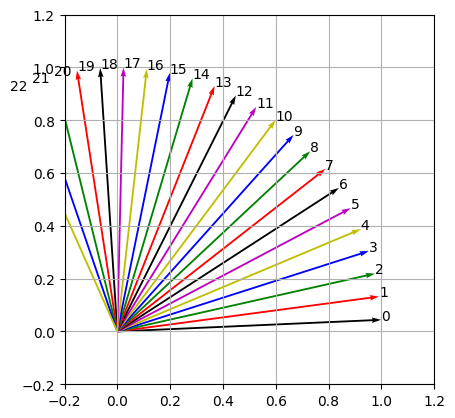

In [3]:


def plot_grover(g):

    colors_of = ['k','r','g','b','y','m']
    plt.xlim(-.2, 1.2)
    plt.ylim(-.2, 1.2)
    plt.grid()
    axes = plt.gca()
    axes.set_aspect(1.0)

    for i in range(g.iter+5):
        x, y = g.coords()
        plt.quiver([0],[0],[x],[y],color=colors_of[i%len(colors_of)], angles='xy', 
                   scale_units='xy', scale=1, width=.005)
        plt.text(x,y,i)
        print(f'{i}:\t({x:.3f},{y:.3f})')
        g.grover_step()
        
    plt.show()

j = 3
k = 9
plot_grover(Grover(j,k))